```
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
IBM Maximo Application Suite
© Copyright IBM Corp. 2019,2020,2021,2022 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
```

In [1]:
### adds notebook to execution json for testing automation
### fast_execution.json will be used to pass the asset_group_id and device_type to be used in the PMI version notebooks for POC purpose.
notebook_name = "FastStart2021Loader-New"
notebook_precursors = []
import json
from project_lib import Project
project = Project.access()
try:
    store = json.load(project.get_file("fast_execution.json"))
except:
    store = {}
    print("No execution json found, initialising with current notebook information")
store[notebook_name] = {"precursors":notebook_precursors, "outputs":{}}
store_json = json.dumps(store)
project.save_data("fast_execution.json", store_json, overwrite=True)
print("Notebook added to json")

for precursor in notebook_precursors:
    for nb in store:
        if precursor == nb:
            #Found precursor. Check if it has output(meaning it has been run)
            if store[precursor]["outputs"] == None or store[precursor]["outputs"] == [None] or store[precursor]["outputs"] == []:
                #Precursor has not been run. Must run before notebook can be run
                raise ValueError(precursor + " must run before this notebook.")

Notebook added to json


In [2]:
!hostname

jupyter-py38-3e42415d-65bc-4c32-84b0-4f92d96aa409-67b897b9vrwh9


## Part 1 - Introduction


The notebooks use a sample dataset to show how data can be ingested, and loaded into the backend systems in Maximo-Predict before a data scientist can proceed to train the models.

This notebook should be run to setup the data in Maximo-Predict before scoring. The following flow chart illustrates the sequence of steps, following which this demo can be adapted for any dataset.

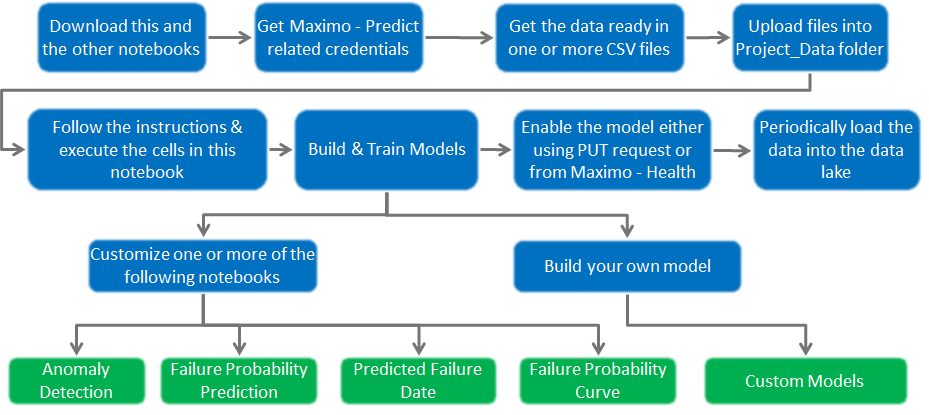

There are 2 notebooks provided including this one. This notebook creates the objects in Maximo-Predict, and loads the essential data into the systems.

This notebook performs a series of operations involving Maximo-Predict as outlined in the following flowchart. Note that it is preferable to delete the objects in the system before recreating them for the demo purposes. The following diagram shows the sequences of delete operations and create operations performed in this notebook. Not following this recommendation could leave corrupt entries behind  causing errors and poor results. 

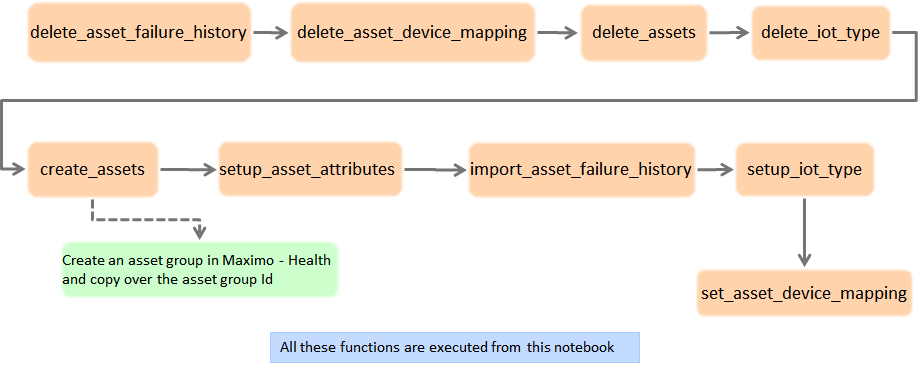

A brief explanation of these operations is as follows

+ **asset_device_mapping**: In reality, assets and their observation (from sensor readings) are usually processed separately. In most cases, asset and sensor data come from and managed by different systems. Maximo-Predict supports getting asset data stored and managed by Maximo, and sensor data from Watson IoT Platform. Assets and sensors are different entities and in order to use both data together, we need to link individual assets and sensors. This is what asset-device mapping is for. Essentially, it indicates for a sensor reading comes in which asset the reading belongs to. An asset can be associated with one or more sensors. On the other hand, a sensor can also be linked to multiple assets, though not common.

+ **Site**: In Maximo, to uniquely identify an asset, you need a site and an asset ID. There are many considerations in planning Maximo organization and site structures, but for our purpose, using assets in Maximo-Predict, we need both site and asset ID in order to identify an asset. If you don't have any site created yet, it's fine to start with site 'BEDFORD' which comes with the sample data set in Maximo.

#### Prerequisites for building the demo

+ Obtain access to Maximo-Predict
+ Get the datasets ready as CSV files (see below)
+ Load all the notebooks into your Watson Studio project

#### Maximo-Predict requires following csv files (dataframes). If your csv files are not in the same format you will need to convert them. We will show you an example in this notebook. 

As you can see in the following formats, there are things that come from your dataset. For example, things like `asset_id` (12 char or less), which is the id of the asset being analyzed, monitored, and studied. However things like `site`, and `devicetype` are the ones you configure in Maximo and IoT platform before embarking on this exercise. 

Except where stated explicitly, the names of the columns are up to the user's choice. It is a matter of preference whether you call it `asset_id` or `equipment_id`. However if your dataset involves a column name different from the one shown here in the example, you need to change the pandas function accordingly in one or more cells below. If you would rather avoid that exercise, then prepare your data using the following structure including the column names to the extent possible. 

Likewise the variable names are also changeable. Instead of calling your IoT object `devicetype`, you can choose to call it `iot_device_type`, so that you can use the word `devicetype` (or `device_type`) for something in your dataset. But if you choose to change any of the variables declared here, then it is important you modify the place(s) where the variables are used.

It should be noted that the column names could be case sensitive in various systems, and certainly so in Pandas. Therefore it is safer to use a consistent case across your variables and other names.

+ Combined Asset and Asset Attribute csv file (dataframe) format -

| asset_id | installation_timestamp | site |
| ----- | ----- | ---- |  
| LOBA20 | 2017-01-19 05:46:29 | BEDFORD|  

+ Asset failure history csv file (dataframe) format -

| asset_id | timestamp | site | deviceid |
|------------| ------- | ------------ | ------ |
| LOBA20 |  2017-01-19 23:29:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-07 00:18:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-08 09:20:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-09 09:06:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-17 13:41:00 | BEDFORD | LOBSensor20191004_1 |

+ IOT sensor csv file (dataframe) format -


| asset_id | timestamp | var1 | var2| var3 | ...... | var_n| deviceid | devicetype |
|------------| ------- | ------------ | ------ | -------|-------|--------|------------|----------------|
| LOBA20 |  2017-01-19 23:29:00 | 34.35 | 65.86 |467.39| ....| 464.73|LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  2017-01-21 17:38:48 | 47.48 | 38.59 | 483.49| ....|463.59|LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  2017-01-19 21:59:37 | 36.67 | 37.76 | 294.65| ....|120.57|LOBSensor20191004_1 | LOBSensor20191004 |


+ Asset-Device mapping csv file (dataframe) format - 

| asset_id | site   | deviceid | devicetype|
|------------| ------- | ------------ | ------ |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |

## Install the Maximo Predict SDK

You will need follow 4 credentials to run the notebook. You can obtain first 3 credentials if you are admin on Maximo Predict UI. Otherwise, you will have to get these from your admin.

You will only have to follow these steps for the first notebook. So, if you have already created the `Predict_Envs.json` file, you can skip ahead to running this notebook.

Steps

- APM_ID: Application Administration -> System Properties -> Filter -> Search PMIId -> Current Value
- APM_API_BASEURL: Application Administration -> Integration -> End Points--> Searh for predict -> click search result PREDICTAPI -> URL (note you just need first part of the url)
- APM_API_KEY: Application Administration -> Go To Administration -> Copy key from user card, or Add API key for the user if API key does not exist.

Step to get db2_certificate.pem:

- Login CP4D. Click Services->Instances. Click the Predict DB. Click "Download SSL Certificate" and save it to the file named as db2_certificate.pem. Then upload the db2_certificate.pem to the CP4D by click "New data Asset".

These can then be placed in a file called `Predict_Envs.json`, formatted like this:

```json
{
  "APM_ID": "*******",
  "APM_API_BASEURL": "https://*********",
  "APM_API_KEY": "**************************",
  "USER_PROVIDED_HEALTH_URL": "",
  "USER_PROVIDED_DB_CONNECTION_STRING": "",
  "USER_PROVIDED_URL": ""
}
```

The three `USER_PROVIDED_*` fields are only necessary if connecting to a deployment not in this CP4D environment.

After creating the JSON file, add it as a data asset to the current project in CP4D.

The code below pulls the credentials from that JSON file and sets them as environment variables in this runtime.


In [3]:
import json
import os

# Opening JSON file
f = open('/project_data/data_asset/hc_Predict_Envs.json',)
data = json.load(f)
f.close()

os.environ['APM_ID'] = data['APM_ID']
os.environ['APM_API_BASEURL'] = data['APM_API_BASEURL']
os.environ['APM_API_KEY'] = data['APM_API_KEY']

# README: Change to true if Health/Predict are deployed on different cluster from this CP4D environment
use_external = False
if use_external:
    import os
    os.environ['USER_PROVIDED_HEALTH_URL'] = data['USER_PROVIDED_HEALTH_URL']
    os.environ['USER_PROVIDED_DB_CONNECTION_STRING'] = data['USER_PROVIDED_DB_CONNECTION_STRING']
    os.environ['USER_PROVIDED_URL'] = data['USER_PROVIDED_URL']

In [4]:
import os

os.environ['SSL_VERIFY_APM'] = 'False'
os.environ['SSL_VERIFY_AS'] = 'False'

os.environ['TRUST_PREDICT'] = os.getenv('APM_API_BASEURL')[8:]
print(os.getenv('TRUST_PREDICT'))

main.predict.ivt11rel87.ivt.suite.maximo.com


In [5]:
import os
os.environ['TRUST_PREDICT'] = os.getenv('APM_API_BASEURL')[8:]
print(os.getenv('TRUST_PREDICT'))

main.predict.ivt11rel87.ivt.suite.maximo.com


Finally, install pmlib with `pip`:

In [6]:
!pip install --trusted-host ${TRUST_PREDICT} ${APM_API_BASEURL}/ibm/pmi/service/rest/ds/${APM_ID}/${APM_API_KEY}/lib/download?filename=pmlib

     |████████████████████████████████| 189.3 MB 69.3 MB/s eta 0:00:01   |▉                               | 5.2 MB 35.8 MB/s eta 0:00:06     |█████▋                          | 33.5 MB 35.8 MB/s eta 0:00:05     |█████████████████               | 99.9 MB 61.5 MB/s eta 0:00:02     |█████████████████▉              | 105.3 MB 61.5 MB/s eta 0:00:02     |███████████████████▉            | 117.5 MB 61.5 MB/s eta 0:00:02
Processing //tmp/1000690000/pip-req-build-eb27uwpu/dslib/srom-1.4.0rc7.1.0-cp38-cp38-linux_x86_64.whl
Processing //tmp/1000690000/pip-req-build-eb27uwpu/dslib/dqlearn-0.4.2.1.0-cp38-cp38-linux_x86_64.whl
Processing //tmp/1000690000/pip-req-build-eb27uwpu/dslib/aixclient.zip
     |████████████████████████████████| 177 kB 23.2 MB/s eta 0:00:01
     |████████████████████████████████| 138 kB 65.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 74.0 MB/s eta 0:00:01
     |████████████████████████████████| 167 kB 48.7 MB/s eta 0:00:01
     |████████████████████████████

     |████████████████████████████████| 120 kB 54.7 MB/s eta 0:00:01
     |████████████████████████████████| 882 kB 77.7 MB/s eta 0:00:01
     |████████████████████████████████| 872 kB 26.9 MB/s eta 0:00:01
     |████████████████████████████████| 322 kB 86.2 MB/s eta 0:00:01
     |████████████████████████████████| 284 kB 86.4 MB/s eta 0:00:01
     |████████████████████████████████| 872 kB 43.1 MB/s eta 0:00:01
     |████████████████████████████████| 871 kB 35.1 MB/s eta 0:00:01         | 245 kB 35.1 MB/s eta 0:00:01
     |████████████████████████████████| 856 kB 31.4 MB/s eta 0:00:01
     |████████████████████████████████| 856 kB 33.1 MB/s eta 0:00:01
     |████████████████████████████████| 855 kB 40.4 MB/s eta 0:00:01
     |████████████████████████████████| 853 kB 30.2 MB/s eta 0:00:01
     |████████████████████████████████| 851 kB 21.2 MB/s eta 0:00:01
     |████████████████████████████████| 841 kB 29.0 MB/s eta 0:00:01                | 245 kB 29.0 MB/s eta 0:00:01
     |████████████

     |████████████████████████████████| 822 kB 51.9 MB/s eta 0:00:01
     |████████████████████████████████| 802 kB 76.6 MB/s eta 0:00:01█▉                      | 245 kB 76.6 MB/s eta 0:00:01
     |████████████████████████████████| 802 kB 33.1 MB/s eta 0:00:01
     |████████████████████████████████| 793 kB 48.9 MB/s eta 0:00:01
     |████████████████████████████████| 793 kB 32.3 MB/s eta 0:00:01ta 0:00:01
     |████████████████████████████████| 791 kB 55.2 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 13.3 MB/s eta 0:00:01


     |████████████████████████████████| 132 kB 33.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 58.5 MB/s eta 0:00:01
     |████████████████████████████████| 87 kB 6.2 MB/s  eta 0:00:01
     |████████████████████████████████| 131 kB 30.9 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 46.1 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 38.0 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 30.4 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 66.5 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 84.8 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 93.0 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 12.2 MB/s eta 0:00:01
  Created wheel for pmlib: filename=pmlib-8.5.1-py3-none-any.whl size=944216 sha256=fa53125eb9822c3bd9a43eb39ce02149135060b901e35cf821a927bd48b5847b
  Stored in directory: /tmp/1000690000/pip-ephem-wheel-cache-z6y8oji8/wheels/4c/fc/50/6a718c81

      Successfully uninstalled jupyter-core-4.7.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.9
    Uninstalling decorator-5.0.9:
      Successfully uninstalled decorator-5.0.9
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.6
    Uninstalling urllib3-1.26.6:
      Successfully uninstalled urllib3-1.26.6
  Attempting uninstall: idna
    Found existing installation: idna 2.8
    Uninstalling idna-2.8:
      Successfully uninstalled idna-2.8
  Attempting uninstall: certifi
    Found existing installation: certifi 2021.10.8
    Uninstalling certifi-2021.10.8:
      Successfully uninstalled certifi-2021.10.8
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully

#### Import pmlib

In [7]:
# Initialize the Maximo-Predict environment variables

import pmlib
from pmlib import api
api.init_environ()

2022-07-01T13:13:31.290 tensorflow.<module> DEBUG Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
2022-07-01T13:13:32.187 pmlib.api.init_environ INFO APM_ID=d17a8d18, APM_API_BASEURL=https://main.predict.ivt11rel87.ivt.suite.maximo.com, APM_API_KEY=********
2022-07-01T13:13:32.189 pmlib.util.api_request INFO method=get, url=https://main.predict.ivt11rel87.ivt.suite.maximo.com/ibm/pmi/service/rest/ds/tenant?instanceId=d17a8d18, headers={'apmapitoken': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-01T13:13:33.429 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://main.predict.ivt11rel87.ivt.suite.maximo.com/ibm/pmi/service/rest/ds/tenant?instanceId=d17a8d18
2022-07-01T13:13:33.433 pmlib.api.init_environ DEBUG resp={
    "as_apikey": "********",
    "as_apitoken": "********",
    "as_id": null,
    "as_url": "https://main.api.monitor.ivt11rel87.ivt

('d17a8d18',
 'https://main.predict.ivt11rel87.ivt.suite.maximo.com',
 'hhgjlmhelthqhacki6s820cdb2qotp3o0pgvaob8')

In [8]:
import pandas as pd
import numpy as np
import requests

import json
import os
import time
from datetime import datetime
from datetime import timedelta
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simple_filter = simplefilter(action='once', category=UserWarning)

#### Define some initial values

You will define your own device_type, site_id, asset_prefix and install_date for your training dataset.

Please mark down device_type used here. You will need it in future notebooks

In [9]:
newAssetPrefix = 'HC_NEW_'
oem_prefix = 'OEMGRP'
afm_prefix = 'AFMGRP'
default_device_type = 'PUMP_HC'
default_site_id = 'BEDFORD'


device_ids_oem = ['HC_PMPDEVICE00']
print(device_ids_oem)

device_ids_afm = [newAssetPrefix+'DEVICE00'+str(n) for n in range(1, 10, 2)]
print(device_ids_afm)

asset_group_label_oem = newAssetPrefix + oem_prefix
asset_group_label_afm = newAssetPrefix + afm_prefix

print('asset_group_label_oem = '+asset_group_label_oem)
print('asset_group_label_afm = '+asset_group_label_afm)


device_type_oem = default_device_type
device_type_afm = default_device_type

['HC_PMPDEVICE00']
['HC_NEW_DEVICE001', 'HC_NEW_DEVICE003', 'HC_NEW_DEVICE005', 'HC_NEW_DEVICE007', 'HC_NEW_DEVICE009']
asset_group_label_oem = HC_NEW_OEMGRP
asset_group_label_afm = HC_NEW_AFMGRP


In [10]:
store[notebook_name]["outputs"]["device_type"] = default_device_type

In [11]:
# define column name variables so they are consistent
install_date_col_name = 'installdate'
timestamp_col_name = 'evt_timestamp'
site_id_col_name = 'site_id'

fail_date_col_name = 'fail_date'
decommission_date_col_name = 'decommission_date'
asset_id_col_name = 'asset_id'
device_type_col_name = 'devicetype'
device_id_col_name = 'deviceid'

## Part 3 - Load the Data Into Dataframes

We will load three separate CSV files containing basic metadata about the devices, sensor readings from the devices, and failure information from the devices.

In [12]:
# load install and decommission dates for assets
asset_installation_decommission_dates_df = pd.read_csv('/project_data/data_asset/hc_asset_attributes.csv')

asset_installation_decommission_dates_df['installdate'] = pd.to_datetime(asset_installation_decommission_dates_df['installdate'])
asset_installation_decommission_dates_df.rename(columns={'installdate': install_date_col_name}, inplace=True)

asset_installation_decommission_dates_df['decommission_date'] = pd.to_datetime(asset_installation_decommission_dates_df['decommission_date'])
print(asset_installation_decommission_dates_df.shape)
asset_installation_decommission_dates_df.replace(to_replace=r'^PMP*', value=newAssetPrefix, regex=True, inplace=True)
asset_installation_decommission_dates_df.head(10)

(1, 3)


asset_id installdate decommission_date
0  hc_pump  2008-01-08               NaT

In [13]:
# load sensor data for assets
sensor_data_afm_df = pd.read_csv('/project_data/data_asset/hc_iot_sensor.csv')
sensor_data_afm_df['devicetype'] = device_type_afm

print(sensor_data_afm_df.shape)
sensor_data_afm_df.head()

(220320, 16)


asset_id    timestamp  sensor_10  sensor_04  sensor_02  sensor_12  \
0  hc_pump  4/1/18 0:00   37.22740   634.3750    53.2118   31.11716   
1  hc_pump  4/1/18 0:01   37.22740   634.3750    53.2118   31.11716   
2  hc_pump  4/1/18 0:02   37.86777   638.8889    53.2118   32.08894   
3  hc_pump  4/1/18 0:03   38.57977   628.1250    53.1684   31.67221   
4  hc_pump  4/1/18 0:04   39.48939   636.4583    53.2118   31.95202   

   sensor_05  sensor_00  sensor_11  sensor_13  sensor_06  sensor_01  \
0   76.45975   2.465394   47.52422   1.681353   13.41146   47.09201   
1   76.45975   2.465394   47.52422   1.681353   13.41146   47.09201   
2   73.54598   2.444734   48.17723   1.708474   13.32465   47.35243   
3   76.98898   2.460474   48.65607   1.579427   13.31742   47.09201   
4   76.58897   2.445718   49.06298   1.683831   13.35359   47.13541   

   sensor_09  sensor_26   deviceid devicetype  
0   15.05353   848.0708  hc_pump00    PUMP_HC  
1   15.05353   848.0708  hc_pump00    PUMP_HC  
2   15.01013   849.8997  hc_pump00    PUMP_HC  
3   15.08247   847.7579  hc_pump00    PUMP_HC  
4   15.08247   846.9182  hc_pump00    PUMP_HC

In [14]:
# update the device IDs with your specified new asset prefix
sensor_data_afm_df.replace(to_replace=r'^PMP*', value=newAssetPrefix, regex=True, inplace=True)
sensor_data_afm_df.head()

# convert timestamp column to a datetime
timestamp_col_csv = 'timestamp'
sensor_data_afm_df[timestamp_col_csv] = pd.to_datetime(sensor_data_afm_df[timestamp_col_csv])

# rename column because Maximo uses the name 'evt_timestamp'
sensor_data_afm_df = sensor_data_afm_df.rename(columns={timestamp_col_csv: timestamp_col_name})

sensor_data_afm_df.head()


asset_id       evt_timestamp  sensor_10  sensor_04  sensor_02  sensor_12  \
0  hc_pump 2018-04-01 00:00:00   37.22740   634.3750    53.2118   31.11716   
1  hc_pump 2018-04-01 00:01:00   37.22740   634.3750    53.2118   31.11716   
2  hc_pump 2018-04-01 00:02:00   37.86777   638.8889    53.2118   32.08894   
3  hc_pump 2018-04-01 00:03:00   38.57977   628.1250    53.1684   31.67221   
4  hc_pump 2018-04-01 00:04:00   39.48939   636.4583    53.2118   31.95202   

   sensor_05  sensor_00  sensor_11  sensor_13  sensor_06  sensor_01  \
0   76.45975   2.465394   47.52422   1.681353   13.41146   47.09201   
1   76.45975   2.465394   47.52422   1.681353   13.41146   47.09201   
2   73.54598   2.444734   48.17723   1.708474   13.32465   47.35243   
3   76.98898   2.460474   48.65607   1.579427   13.31742   47.09201   
4   76.58897   2.445718   49.06298   1.683831   13.35359   47.13541   

   sensor_09  sensor_26   deviceid devicetype  
0   15.05353   848.0708  hc_pump00    PUMP_HC  
1   15.05353   848.0708  hc_pump00    PUMP_HC  
2   15.01013   849.8997  hc_pump00    PUMP_HC  
3   15.08247   847.7579  hc_pump00    PUMP_HC  
4   15.08247   846.9182  hc_pump00    PUMP_HC

In [15]:
# load failure data for assets
failure_data_afm_df = pd.read_csv('/project_data/data_asset/hc_asset_failure_history.csv')

print(failure_data_afm_df.shape)
failure_data_afm_df.head()

(7, 4)


asset_id      fail_date     site   deviceid
0  HC_PUMP  4/12/18 21:55  BEDFORD  HC_PUMP00
1  HC_PUMP   4/18/18 0:30  BEDFORD  HC_PUMP00
2  HC_PUMP   5/19/18 3:18  BEDFORD  HC_PUMP00
3  HC_PUMP   5/25/18 0:30  BEDFORD  HC_PUMP00
4  HC_PUMP  6/28/18 22:00  BEDFORD  HC_PUMP00

In [16]:
# update the device IDs with your specified new asset prefix
failure_data_afm_df.replace(to_replace=r'^PMP*', value=newAssetPrefix, regex=True, inplace=True)

# convert timestamp column to a datetime
failure_data_afm_df['fail_date'] = pd.to_datetime(failure_data_afm_df['fail_date'])

failure_data_afm_df.head()

asset_id           fail_date     site   deviceid
0  HC_PUMP 2018-04-12 21:55:00  BEDFORD  HC_PUMP00
1  HC_PUMP 2018-04-18 00:30:00  BEDFORD  HC_PUMP00
2  HC_PUMP 2018-05-19 03:18:00  BEDFORD  HC_PUMP00
3  HC_PUMP 2018-05-25 00:30:00  BEDFORD  HC_PUMP00
4  HC_PUMP 2018-06-28 22:00:00  BEDFORD  HC_PUMP00

## Part 4 - Add a Timeshift to make data more recent (Optional)

The data in the CSV is from 2008. Using this section, you can shift the data so it occurs more recently. It is only recommended to run this section once, as running it multiple times with shift your data into the future.

#### Change Sensor DataFrame

In [17]:
# observe old min/max
print(f'old sensor DF min date: {sensor_data_afm_df[timestamp_col_name].min()}')
print(f'old sensor DF max date: {sensor_data_afm_df[timestamp_col_name].max()}')

old sensor DF min date: 2018-04-01 00:00:00
old sensor DF max date: 2018-08-31 23:59:00


In [18]:
# step 1 - calculate timeshift
timeshift = (datetime.now() - sensor_data_afm_df[timestamp_col_name].max() - timedelta(days=60)).days
print(f'Shifting {timeshift} days forward')

Shifting 1339 days forward


In [19]:
# step 2 - perform timeshift
sensor_data_afm_df[timestamp_col_name] = sensor_data_afm_df[timestamp_col_name] + timedelta(days=timeshift)

In [20]:
# observe new min/max
print(f'new sensor DF min date: {sensor_data_afm_df[timestamp_col_name].min()}')
print(f'new sensor DF max date: {sensor_data_afm_df[timestamp_col_name].max()}')

new sensor DF min date: 2021-11-30 00:00:00
new sensor DF max date: 2022-05-01 23:59:00


#### Change Failure DataFrame

In [21]:
# observe old min/max
print(f'old failure DF min date: {failure_data_afm_df[fail_date_col_name].min()}')
print(f'old failure DF max date: {failure_data_afm_df[fail_date_col_name].max()}')

old failure DF min date: 2018-04-12 21:55:00
old failure DF max date: 2018-07-25 14:00:00


In [22]:
# step 3 - perform timeshift on failure date
failure_data_afm_df[fail_date_col_name] = failure_data_afm_df[fail_date_col_name] + timedelta(days=timeshift)

In [23]:
# observe new min/max
print(f'new failure DF min date: {failure_data_afm_df[fail_date_col_name].min()}')
print(f'new failure DF max date: {failure_data_afm_df[fail_date_col_name].max()}')

new failure DF min date: 2021-12-11 21:55:00
new failure DF max date: 2022-03-25 14:00:00


## Part 5 - Clean up DataFrames

This section creates and changes the dataframes so they work when we add them to Maximo.

In [24]:
asset_all_df = asset_installation_decommission_dates_df

# add devicetype column to DF; map each device to it's proper device type- either AFM or OEM
asset_all_df[device_type_col_name] = asset_all_df[asset_id_col_name].map(
    lambda x: device_type_oem if x in list(sensor_data_afm_df[asset_id_col_name].unique()) else device_type_afm)

asset_all_df[device_id_col_name] = asset_all_df[asset_id_col_name]

asset_all_df[site_id_col_name] = default_site_id
asset_all_df.head()


asset_id installdate decommission_date devicetype deviceid  site_id
0  hc_pump  2008-01-08               NaT    PUMP_HC  hc_pump  BEDFORD

Construct asset device mapping- Maximo will use these to determine which asset group your devices below to.

In [25]:
asset_device_mapping_df = asset_all_df.drop([install_date_col_name, decommission_date_col_name], axis=1)
asset_device_mapping_df.head()


asset_id devicetype deviceid  site_id
0  hc_pump    PUMP_HC  hc_pump  BEDFORD

## Part 6 - Delete existing data

In the next few cells the objects in Maximo-Predict data lake are going to be deleted. This is to make sure you can recreate this flow as many times as necessary (or if something goes wrong in the first attempt).

Note that we delete all the events here including both training and testing segments. This is being done in order to minimize calls across the wire to the underlying system (Maximo). This is fine as long as the dataset is small in size, for large datasets this will unnecessarily increase the memory footprint. In that case you may be better off not combining things into one dataset.

In [51]:
failure_data_afm_df.rename(columns={'site': site_id_col_name}, inplace=True)
failure_data_afm_df.head()

asset_id           fail_date  site_id   deviceid
0  HC_PUMP 2021-12-11 21:55:00  BEDFORD  HC_PUMP00
1  HC_PUMP 2021-12-17 00:30:00  BEDFORD  HC_PUMP00
2  HC_PUMP 2022-01-17 03:18:00  BEDFORD  HC_PUMP00
3  HC_PUMP 2022-01-23 00:30:00  BEDFORD  HC_PUMP00
4  HC_PUMP 2022-02-26 22:00:00  BEDFORD  HC_PUMP00

In [52]:
resp = pmlib.delete_asset_failure_history(failure_data_afm_df, siteid_column=site_id_col_name, assetid_column=asset_id_col_name)
print(resp)

2022-07-01T13:27:22.576 pmlib.api._maximo_bulk_delete DEBUG resource_query=oslc.where=assetnum in ["HC_PUMP"] and wonum="APM%25" and siteid="BEDFORD"
2022-07-01T13:27:22.579 pmlib.util.api_request INFO method=get, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiwodetail?lean=1&oslc.where=assetnum in ["HC_PUMP"] and wonum="APM%25" and siteid="BEDFORD", headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-01T13:27:22.671 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiwodetail?lean=1&oslc.where=assetnum in ["HC_PUMP"] and wonum="APM%25" and siteid="BEDFORD"
2022-07-01T13:27:22.674 pmlib.util.api_request INFO method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiwodetail?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[{'_meta': {'uri': 'h

In [53]:
# delete asset_device mapping for training
pmlib.delete_asset_device_mappings(df=asset_device_mapping_df, siteid_column=site_id_col_name, assetid_column=asset_id_col_name)

2022-07-01T13:27:25.469 pmlib.api._get_db INFO db2
2022-07-01T13:27:25.472 pmlib.api._get_db INFO db2
2022-07-01T13:27:25.474 pmlib.api._get_db INFO DATABASE=BLUDB;HOSTNAME=c-db2wh-1647023654076709-db2u-engn-svc.cpd-services.svc;PORT=50001;PROTOCOL=TCPIP;UID=admin;PWD=QbtMBNRHWcXi;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem
2022-07-01T13:27:27.493 iotfunctions.dbtables._store_table_exists DEBUG Table "MAIN_MAM"."KPI_MODEL_STORE" exists.
2022-07-01T13:27:27.501 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-01T13:27:27.503 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-01T13:27:27.510 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE: db2
2022-07-01T13:27:27.511 iotfunctions.db.__init__ DEBUG Found certificate filename in os variable DB_CERTIFICATE_FILE: /project_data/data_ass

In [58]:
# delete training asset
resp = pmlib.delete_assets(asset_all_df, siteid_column=site_id_col_name, assetid_column=asset_id_col_name)
print(resp)

2022-07-01T13:33:54.984 pmlib.api._maximo_bulk_delete DEBUG resource_query=oslc.where=assetnum in ["HC_PUMP"] and siteid="BEDFORD"
2022-07-01T13:33:54.986 pmlib.util.api_request INFO method=get, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiasset?lean=1&oslc.where=assetnum in ["HC_PUMP"] and siteid="BEDFORD", headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-01T13:33:55.050 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiasset?lean=1&oslc.where=assetnum in ["HC_PUMP"] and siteid="BEDFORD"
2022-07-01T13:33:55.054 pmlib.util.api_request INFO method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiasset?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[], session=None, kwargs={}
2022-07-01T13:33:55.120 pmlib.util.api_request INFO resp.st

In [59]:
# delete sensor data from data lake for training
pmlib.delete_iot_type(name=device_type_afm)
time.sleep(300)  # wait 5 minute for AS to finish the job.

2022-07-01T13:33:55.131 pmlib.api._call_wiotp INFO https://main.iot.ivt11rel87.ivt.suite.maximo.com
2022-07-01T13:33:55.132 pmlib.util.api_request INFO method=get, url=https://main.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/device/types/PUMP_HC/devices, headers={}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={'auth': ('a-main-phqyj3sfzy', '+47m+0w2ZY(ffe9Mv5')}
2022-07-01T13:33:55.414 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://main.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/device/types/PUMP_HC/devices
2022-07-01T13:33:55.416 pmlib.api._call_wiotp INFO https://main.iot.ivt11rel87.ivt.suite.maximo.com
2022-07-01T13:33:55.417 pmlib.util.api_request INFO method=post, url=https://main.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/bulk/devices/remove, headers={}, timeout=300, ssl_verify=False, json=[], session=None, kwargs={'auth': ('a-main-phqyj3sfzy', '+47m+0w2ZY(ffe9Mv5')}
2022-07-01T13:33:55.560 pmlib.util.api_request INFO resp.sta

**Note:** Need to wait for 5 minutes before insert

Then, we can create and run some utility functions to delete the old asset group.

In [60]:
from pmlib.api import _call_maximo

# clean up filter and assetgroup
def get_asset_group_href(grouplabel):
    if grouplabel is None:
        raise ValueError('the given argument grouplabel is None')
    resp = _call_maximo(url_path='/os/MXAPIEXPGROUP?lean=1&addid=1&oslc.where=grouplabel=%22'+grouplabel+'%22&oslc.select=*', method='get')
    if resp is not None:
        data = resp.json()
        print(data)
        if len(data['member']) != 0:
            return (data['member'][0]['href'])
    return 0
def delete_asset_group(grouplabel):
    if grouplabel is None:
        raise ValueError('the given argument grouplabel is None')
    href = get_asset_group_href(grouplabel)
    if href != 0 :
        url_path=href.split("/api")[1]
        print(url_path)
        resp = _call_maximo(url_path=url_path, method='delete')
        print(resp)

In [61]:
asset_group_id = pmlib.api.get_maximo_asset_group_id(asset_group_label_afm)
print(asset_group_id)
if asset_group_id is not None:
    url = os.environ.get('APM_API_BASEURL', None) + '/ibm/pmi/service/rest/assetgroup/' + asset_group_id + '?instanceId=' +os.environ.get('APM_ID', None)
    header={
        'apmapitoken':os.environ.get('APM_API_KEY', None)
    }
    response = requests.delete(url, headers=header,verify=False)
    print(response)

delete_asset_group(asset_group_label_afm)

2022-07-01T13:38:56.199 pmlib.util.api_request INFO method=get, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiexpgroup?oslc.select=expgroupname&lean=1&querylocalized=1&oslc.where=grouplabel="HC_NEW_AFMGRP", headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-01T13:38:56.288 pmlib.util.api_request INFO resp.status_code=200, method=get, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiexpgroup?oslc.select=expgroupname&lean=1&querylocalized=1&oslc.where=grouplabel="HC_NEW_AFMGRP"
1094
<Response [200]>
2022-07-01T13:39:02.916 pmlib.util.api_request INFO method=get, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/MXAPIEXPGROUP?lean=1&addid=1&oslc.where=grouplabel=%22HC_NEW_AFMGRP%22&oslc.select=*, headers={'apikey': '********'}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={}
2022-07-01T13:39:03.007 pmlib.util.api_request INFO resp.status_code=200, m

## Part 7 - Insert data

Note that this example loads the data into the underlying systems as follows:
+ As for Measurement data, the testing segment is loaded in the data lake as example, but you can choose to load both training and testing segments qualified by different device_type and asset_prefixes . The pattern illustrated here is assuming the training is done using CSV files, and the scoring happens on the data in the data lake & Maximo on an ongoing basis. 
+ The training part of the measurement data is set aside for the training to be done in a separate notebook provided in this package (refer to the notebook titled `DTE_Failure_Probability_Estimation_Training`). 
+ As for the failure data, the entire data is loaded. 

**Now we will start creating the asset objects sensor objects**

Normally, we would manage assets from Maximo. But Maximo-Predict SDK also supports bulk loading assets into Maximo directly from within notebook. This could be useful to load some sample non-existent asset data from CSV files.

1. Invoke the PMLIB API to create the asset in Maximo for training using this dataframe:

In [62]:
asset_all_df.head()

asset_id installdate decommission_date devicetype deviceid  site_id
0  hc_pump  2008-01-08               NaT    PUMP_HC  hc_pump  BEDFORD

In [63]:
resp = pmlib.create_assets(asset_all_df, assetid_column=asset_id_col_name, siteid_column=site_id_col_name)

2022-07-01T13:39:10.453 pmlib.util.api_request INFO method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiasset?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[{'_data': {'assetnum': 'HC_PUMP', 'siteid': 'BEDFORD', 'description': 'HC_PUMP'}}], session=None, kwargs={}
2022-07-01T13:39:10.638 pmlib.util.api_request INFO resp.status_code=200, method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiasset?lean=1
2022-07-01T13:39:10.640 pmlib.api._maximo_bulk_create INFO resp_create=[{"_responsemeta":{"status":"201","Location":"http:\/\/localhost\/maximo\/api\/os\/mxapiasset\/_SENfUFVNUC9CRURGT1JE"}}]


2. Create assets for testing using this dataframe:

In [64]:
asset_all_df.head()

asset_id installdate decommission_date devicetype deviceid  site_id
0  hc_pump  2008-01-08               NaT    PUMP_HC  hc_pump  BEDFORD

In [65]:
resp = pmlib.setup_asset_attributes(asset_all_df, assetid_column=asset_id_col_name, siteid_column=site_id_col_name,
                                    attribute_columns=[install_date_col_name], parse_dates=[install_date_col_name])
print(resp)

2022-07-01T13:39:10.679 pmlib.util.api_request INFO method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiasset?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[{'_data': {'installdate': '2008-01-08T00:00:00', 'assetnum': 'HC_PUMP', 'siteid': 'BEDFORD', 'description': 'HC_PUMP'}}], session=None, kwargs={}
2022-07-01T13:39:10.760 pmlib.util.api_request INFO resp.status_code=200, method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiasset?lean=1
2022-07-01T13:39:10.763 pmlib.api._maximo_bulk_create INFO resp_create=[{"_responsedata":{"Error":{"errorattrname":"assetnum","extendedError":{"moreInfo":{"href":"http:\/\/localhost\/maximo\/api\/error\/messages\/BMXAA4129E"}},"errorobjpath":"asset","correlationid":null,"errattrvalue":null,"reasonCode":"BMXAA4129E","message":"BMXAA4129E - \u30b5\u30a4\u30c8=BEDFORD, \u8cc7\u7523=HC_PUMP \u306e\u30ec\u30b3\u30fc\u30c9\u306f\u65e

3. Create failure history for training using this dataframe:

In [66]:
failure_data_afm_df.head()

asset_id           fail_date  site_id   deviceid
0  HC_PUMP 2021-12-11 21:55:00  BEDFORD  HC_PUMP00
1  HC_PUMP 2021-12-17 00:30:00  BEDFORD  HC_PUMP00
2  HC_PUMP 2022-01-17 03:18:00  BEDFORD  HC_PUMP00
3  HC_PUMP 2022-01-23 00:30:00  BEDFORD  HC_PUMP00
4  HC_PUMP 2022-02-26 22:00:00  BEDFORD  HC_PUMP00

In [67]:
# default_failurecode is the CLASS in the MAXIMO MANAGE
# default_problemcode is the PROBLEMCODE is in the MAXIMO MANAGE
# the Precondition is that default_failurecode and default_problemcode have been set up in MAXIMO MANAGE
resp = pmlib.import_asset_failure_history(failure_data_afm_df, assetid_column='asset_id', siteid_column='site_id',
                                          faildate_column='fail_date', default_failurecode='PUMPS', default_problemcode='STOPPED', wonum_prefix='apm')
print(resp)

2022-07-01T13:39:10.945 pmlib.util.api_request INFO method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiwodetail?lean=1, headers={'X-method-override': 'BULK', 'apikey': '********'}, timeout=300, ssl_verify=False, json=[{'_data': {'faildate': '2021-12-11T21:55:00+00:00', 'failurecode': 'PUMPS', 'problemcode': 'STOPPED', 'assetnum': 'HC_PUMP', 'siteid': 'BEDFORD', 'wonum': 'APM1837294'}}, {'_data': {'faildate': '2021-12-17T00:30:00+00:00', 'failurecode': 'PUMPS', 'problemcode': 'STOPPED', 'assetnum': 'HC_PUMP', 'siteid': 'BEDFORD', 'wonum': 'APM7485720'}}, {'_data': {'faildate': '2022-01-17T03:18:00+00:00', 'failurecode': 'PUMPS', 'problemcode': 'STOPPED', 'assetnum': 'HC_PUMP', 'siteid': 'BEDFORD', 'wonum': 'APM8705842'}}, {'_data': {'faildate': '2022-01-23T00:30:00+00:00', 'failurecode': 'PUMPS', 'problemcode': 'STOPPED', 'assetnum': 'HC_PUMP', 'siteid': 'BEDFORD', 'wonum': 'APM8129061'}}, {'_data': {'faildate': '2022-02-26T22:00:00+00:00', 'failurecod

**Create Asset Group**

The unit of analysis is asset group. An asset group is a set of assets with similar characteristics, to the intended models, which are used to train models applicable to all assets in the group.

To create an asset group you can call following APIs. Or, go to Maximo-Predict -> Predict Group.

In [68]:
from pmlib.api import _call_maximo


def create_filter(assetFilter, assetNum):
    querypayload = {
        "ispublic": True,
        "clausename": assetFilter
    }
    resp = _call_maximo(url_path='/os/mxapiasset?action=system%3Asavethisquery&oslc.where=siteid=%22BEDFORD%22%20and%20assetnum=%22' +
                        assetNum+'%25%22&lean=1', method='post', json=querypayload)


def create_asset_group(assetGroupLabel, assetFilter):
    group_payload = {
        "usewith": "ASSET",
        "intobjectname": "MXAPIASSET",
        "egtype": "FILTER",
        "clausename": assetFilter,
        "usedby": "PMI",
        "grouplabel": assetGroupLabel
    }
    resp = _call_maximo(url_path='/os/MXAPIEXPGROUP?lean=1', method='post', json=group_payload)

In [69]:
create_filter(asset_group_label_afm, newAssetPrefix)
create_asset_group(asset_group_label_afm, asset_group_label_afm)
asset_group_afm_id = api.get_maximo_asset_group_id(asset_group_label_afm)

2022-07-01T13:39:12.384 pmlib.util.api_request INFO method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiasset?action=system%3Asavethisquery&oslc.where=siteid=%22BEDFORD%22%20and%20assetnum=%22HC_NEW_%25%22&lean=1, headers={'apikey': '********'}, timeout=300, ssl_verify=False, json={'ispublic': True, 'clausename': 'HC_NEW_AFMGRP'}, session=None, kwargs={}
2022-07-01T13:39:13.655 pmlib.util.api_request INFO resp.status_code=200, method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/mxapiasset?action=system%3Asavethisquery&oslc.where=siteid=%22BEDFORD%22%20and%20assetnum=%22HC_NEW_%25%22&lean=1
2022-07-01T13:39:13.658 pmlib.util.api_request INFO method=post, url=https://ivt11rel87-main.mas-ivt11rel87-health.svc/maximo/api/os/MXAPIEXPGROUP?lean=1, headers={'apikey': '********'}, timeout=300, ssl_verify=False, json={'usewith': 'ASSET', 'intobjectname': 'MXAPIASSET', 'egtype': 'FILTER', 'clausename': 'HC_NEW_AFMGRP', 'usedby': 'PMI

A new ID is assigned to your asset group. Save both the ID and the group label, as they will be needed in future notebooks.


In [70]:
print(f'asset group id: {asset_group_afm_id}')
print(f'asset group label: {asset_group_label_afm}')

asset group id: 1095
asset group label: HC_NEW_AFMGRP


In [71]:
store[notebook_name]["outputs"]["asset_group_id"] = asset_group_afm_id

**Setup IOT Devices** 

Maximo-Predict currently supports Watson IOT Platform (WIOTP) as the data source for devices/sensors. In order to allow devices to send events to WIOTP, we have to register devices to WIOTP and setup up properly so the device events go into the data lake.

You can do it from UI, as instructed in IBM Maximo APM - Predictive Maintenance Insights Knowledge Center: Creating device types, Creating physical and logical interfaces, Configuring the integration with IBM Maximo APM - Asset Health Insights.

Or, you can also set it up directly within notebooks. In addition to setting up IOT devices, this method also supports bulk importing your device history data into data lake (from CSV files).

Let's use the just loaded dataframe df_sensor_data as an example. 

In [72]:
sensor_data_afm_df.columns = [asset_id_col_name,timestamp_col_name, 'Current_10', 'Speed_4', 'Frequency_2','Current_12', 
                                'Current_5', 'Vibration_00', 'Current_11','Vibration_13','Power_6','Vibration_1',
                                'Power_9','Speed_26',device_id_col_name, device_type_col_name]
sensor_data_afm_df.head()

asset_id       evt_timestamp  Current_10   Speed_4  Frequency_2  Current_12  \
0  hc_pump 2021-11-30 00:00:00    37.22740  634.3750      53.2118    31.11716   
1  hc_pump 2021-11-30 00:01:00    37.22740  634.3750      53.2118    31.11716   
2  hc_pump 2021-11-30 00:02:00    37.86777  638.8889      53.2118    32.08894   
3  hc_pump 2021-11-30 00:03:00    38.57977  628.1250      53.1684    31.67221   
4  hc_pump 2021-11-30 00:04:00    39.48939  636.4583      53.2118    31.95202   

   Current_5  Vibration_00  Current_11  Vibration_13   Power_6  Vibration_1  \
0   76.45975      2.465394    47.52422      1.681353  13.41146     47.09201   
1   76.45975      2.465394    47.52422      1.681353  13.41146     47.09201   
2   73.54598      2.444734    48.17723      1.708474  13.32465     47.35243   
3   76.98898      2.460474    48.65607      1.579427  13.31742     47.09201   
4   76.58897      2.445718    49.06298      1.683831  13.35359     47.13541   

    Power_9  Speed_26   deviceid devicetype  
0  15.05353  848.0708  hc_pump00    PUMP_HC  
1  15.05353  848.0708  hc_pump00    PUMP_HC  
2  15.01013  849.8997  hc_pump00    PUMP_HC  
3  15.08247  847.7579  hc_pump00    PUMP_HC  
4  15.08247  846.9182  hc_pump00    PUMP_HC

In [73]:
features_for_training=list(set(list(sensor_data_afm_df.columns))- set(['asset_id','evt_timestamp','deviceid','devicetype']))
features_for_training

['Current_11',
 'Frequency_2',
 'Current_5',
 'Power_9',
 'Current_10',
 'Power_6',
 'Vibration_00',
 'Current_12',
 'Speed_4',
 'Vibration_1',
 'Speed_26',
 'Vibration_13']

In [74]:
# Loading the training data. Note that this training data is used from a CSV file in a separate notebook
t = pmlib.setup_iot_type(
    name=device_type_afm,
    df=sensor_data_afm_df,
    columns=features_for_training,
    deviceid_column=device_id_col_name,
    timestamp_column=timestamp_col_name,
    timestamp_in_payload=True,
    # write='deletefirst',
    write='dropfirst',
    use_wiotp=True,  # may create extra rows
    import_only=False)  # True or False depends on whether your device type is already there in the system or not.

2022-07-01T13:39:13.922 pmlib.api._call_wiotp INFO https://main.iot.ivt11rel87.ivt.suite.maximo.com
2022-07-01T13:39:13.923 pmlib.util.api_request INFO method=get, url=https://main.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/device/types/PUMP_HC, headers={}, timeout=300, ssl_verify=False, json=None, session=None, kwargs={'auth': ('a-main-phqyj3sfzy', '+47m+0w2ZY(ffe9Mv5')}
2022-07-01T13:39:14.072 pmlib.util.api_request INFO resp.status_code=404, method=get, url=https://main.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/device/types/PUMP_HC
2022-07-01T13:39:14.074 pmlib.util.api_request WARNING error api request: url=https://main.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/device/types/PUMP_HC, method=get, status_code=404, response_text={"message":"CUDRS0054E: Device type PUMP_HC does not exist in this organization.","exception":{"id":"CUDRS0054E","properties":["PUMP_HC"]}}
2022-07-01T13:39:14.076 pmlib.util.api_request INFO method=get, url=https://main.api.monitor.ivt11rel87.ivt.su

2022-07-01T13:39:21.656 pmlib.util.api_request INFO resp.status_code=201, method=post, url=https://main.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/draft/event/types
2022-07-01T13:39:21.658 pmlib.api.create_wiotp_pi_li_mappings INFO created event_type_id=62bef90910f34a746b624094 using schema_id=62bef90910f34a746b624093 for physical interface
2022-07-01T13:39:21.660 pmlib.api._call_wiotp INFO https://main.iot.ivt11rel87.ivt.suite.maximo.com
2022-07-01T13:39:21.661 pmlib.util.api_request INFO method=post, url=https://main.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/draft/physicalinterfaces, headers={}, timeout=300, ssl_verify=False, json={'name': 'btsensor_PI', 'description': ''}, session=None, kwargs={'auth': ('a-main-phqyj3sfzy', '+47m+0w2ZY(ffe9Mv5')}
2022-07-01T13:39:21.748 pmlib.util.api_request INFO resp.status_code=201, method=post, url=https://main.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/draft/physicalinterfaces
2022-07-01T13:39:21.751 pmlib.api.create_wiotp_pi_li_mappi

2022-07-01T13:39:31.314 pmlib.util.api_request INFO resp.status_code=200, method=post, url=https://main.messaging.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/device/types/PUMP_HC/devices/hc_pump00/events/sensorevent
2022-07-01T13:39:31.317 pmlib.api._call_wiotp INFO https://main.messaging.iot.ivt11rel87.ivt.suite.maximo.com
2022-07-01T13:39:31.319 pmlib.util.api_request INFO method=post, url=https://main.messaging.iot.ivt11rel87.ivt.suite.maximo.com/api/v0002/device/types/PUMP_HC/devices/hc_pump00/events/sensorevent, headers={}, timeout=300, ssl_verify=False, json={'vibration_1': 0, 'current_5': 0, 'vibration_00': 0, 'speed_4': 0, 'power_6': 0, 'speed_26': 0, 'evt_timestamp': '2022-07-01T13:39:31.086380+00:00', 'power_9': 0, 'current_10': 0, 'current_12': 0, 'vibration_13': 0, 'frequency_2': 0, 'current_11': 0}, session=None, kwargs={'auth': ('use-token-auth', '+47m+0w2ZY(ffe9Mv5')}
2022-07-01T13:39:31.486 pmlib.util.api_request INFO resp.status_code=200, method=post, url=https://mai

2022-07-01T13:39:31.868 iotfunctions.metadata.register DEBUG found METRIC column current_12
2022-07-01T13:39:31.870 iotfunctions.metadata.register DEBUG found METRIC column vibration_13
2022-07-01T13:39:31.871 iotfunctions.metadata.register DEBUG found METRIC column frequency_2
2022-07-01T13:39:31.872 iotfunctions.metadata.register DEBUG found METRIC column current_11
2022-07-01T13:39:31.873 iotfunctions.metadata.register DEBUG found METRIC column rcv_timestamp_utc
2022-07-01T13:39:31.875 iotfunctions.db.http_request DEBUG URL: https://main.api.monitor.ivt11rel87.ivt.suite.maximo.com/api/v2/core/deviceTypes
2022-07-01T13:39:32.500 iotfunctions.db.http_request DEBUG payload: b'{"name": "PUMP_HC", "metricTableName": null, "metricTimestampColumn": "evt_timestamp", "description": "", "origin": "AS_SAMPLE", "dataItemDto": [{"name": "devicetype", "type": "METRIC", "columnName": "devicetype", "columnType": "LITERAL", "tags": null, "transient": false}, {"name": "deviceid", "type": "METRIC", "c

2022-07-01T13:39:32.715 pmlib.util.api_request INFO resp.status_code=200, method=post, url=https://main.api.monitor.ivt11rel87.ivt.suite.maximo.com/api/v2/core/deviceTypes/search?status=ACTIVE&offset=0&limit=100
IOT_DEVICE_TYPE_124
2022-07-01T13:39:32.719 pmlib.api.create_entity_type DEBUG new_table_name=IOT_DEVICE_TYPE_124
2022-07-01T13:39:32.817 iotfunctions.db.get_table DEBUG Table name = IOT_DEVICE_TYPE_124 , self.metadata = MetaData(bind=Engine(db2+ibm_db://admin:***@c-db2wh-1647023654076709-db2u-engn-svc.cpd-services.svc:50001/BLUDB;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem;))  
2022-07-01T13:39:32.896 pmlib.api._write_dataframe DEBUG df_before_tosql=
shape=(220320, 16), 
index={0: 'int64'}, 
columns={'vibration_1': 'float64', 'current_5': 'float64', 'vibration_00': 'float64', 'speed_4': 'float64', 'power_6': 'float64', 'speed_26': 'float64', 'evt_timestamp': datetime64[ns, UTC], 'devicetype': 'O', 'power_9': 'float64', 'updated_utc': '<M8[ns]

/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/pandas/io/sql.py:1444: UserWarning: The provided table name 'IOT_DEVICE_TYPE_124' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  warnings.warn(msg, UserWarning)


In [75]:
# set asset device mappings for training
pmlib.set_asset_device_mappings(df=asset_device_mapping_df, delete_df_asset_first=True, drop_table_first=False,
                                deviceid_column=device_id_col_name, devicetype_column=device_type_col_name,
                                assetid_column=asset_id_col_name, siteid_column=site_id_col_name)

2022-07-01T13:40:02.320 pmlib.api._get_db INFO db2
2022-07-01T13:40:02.322 pmlib.api._get_db INFO db2
2022-07-01T13:40:02.325 pmlib.api._get_db INFO DATABASE=BLUDB;HOSTNAME=c-db2wh-1647023654076709-db2u-engn-svc.cpd-services.svc;PORT=50001;PROTOCOL=TCPIP;UID=admin;PWD=QbtMBNRHWcXi;SECURITY=SSL;SSLServerCertificate=/project_data/data_asset/db2_certificate.pem
2022-07-01T13:40:04.952 iotfunctions.dbtables._store_table_exists DEBUG Table "MAIN_MAM"."KPI_MODEL_STORE" exists.
2022-07-01T13:40:04.955 iotfunctions.db.__init__ DEBUG Unable to locate message_hub credentials. Database object created, but it will not be able interact with message hub.
2022-07-01T13:40:04.962 iotfunctions.db.__init__ WARNING Unable to locate CORE API URL.. using base API URL
2022-07-01T13:40:04.967 iotfunctions.db.__init__ DEBUG Found database type in os variable DB_TYPE: db2
2022-07-01T13:40:04.971 iotfunctions.db.__init__ DEBUG Found certificate filename in os variable DB_CERTIFICATE_FILE: /project_data/data_ass

## Part 8 - Additional Data (Optional)

This section allows you to load additional data for your devices. In each section, you can customize the date range to use and the device ID. To see the data with your asset group, you need to use one of the device IDs below (i.e., a device you just loaded in):


Load data for a single device:

In [ ]:
# date_range = pd.date_range(start='2021-04-01', periods=30, freq='D')  # example- customize start, end dates, and frequency
# date_range = pd.date_range(start='2021-04-01', end='2021-06-01')  # example- customize start, periods, and frequency
date_range = pd.date_range(start='2021-04-01', periods=30, freq='D')
device_id = 'AFMDEVICE001'

# make up some scoring data for date range
num_values = len(date_range)
velocity_x = np.random.permutation(sensor_data_afm_df['velocityx'].values)[0:num_values]*100
velocity_y = np.random.permutation(sensor_data_afm_df['velocityy'].values)[0:num_values]*100
velocity_z = np.random.permutation(sensor_data_afm_df['velocityz'].values)[0:num_values]*100

motor_temp = np.random.permutation(sensor_data_afm_df['motortemp'].values)[0:num_values]
winding_temp = np.random.permutation(sensor_data_afm_df['windingtemp'].values)[0:num_values]
current = np.random.permutation(sensor_data_afm_df['current'].values)[0:num_values]

pressure = np.random.permutation(sensor_data_afm_df['pressure'].values)[0:num_values]
load = np.random.permutation(sensor_data_afm_df['load'].values)[0:num_values]


df_scoring_data = pd.DataFrame({'velocityx': velocity_x, 'velocityy': velocity_y, 'velocityz': velocity_z, 'motortemp': motor_temp, 'windingtemp': winding_temp, 'CURRENT': current,
                                'pressure': pressure, 'load': load}, columns=['velocityx', 'velocityy', 'velocityz', 'motortemp', 'windingtemp', 'CURRENT', 'pressure', 'load'])
df_scoring_data[timestamp_col_name] = date_range

df_scoring_data[device_type_col_name] = default_device_type
df_scoring_data[device_id_col_name] = device_id
print(df_scoring_data.shape)
df_scoring_data.head()

In [ ]:
t = pmlib.setup_iot_type(
    name=default_device_type,
    df=df_scoring_data,
    columns=['velocityx', 'velocityy', 'velocityz', 'motortemp', 'windingtemp', 'CURRENT', 'pressure', 'load'],
    deviceid_column=device_id_col_name,
    timestamp_column=timestamp_col_name,
    timestamp_in_payload=True,
    write='append',
    use_wiotp=True,
    import_only=True)

Load data for a list of devices:

In [ ]:
date_range = pd.date_range('2021-04-01', periods=30, freq='D')
devices = ['AFMDEVICE001', 'AFMDEVICE003', 'AFMDEVICE007']

# make up some scoring data for date range
num_values = len(date_range)
for pump_id in devices:
    velocity_x = np.random.permutation(sensor_data_afm_df['velocityx'].values)[0:num_values]
    velocity_y = np.random.permutation(sensor_data_afm_df['velocityy'].values)[0:num_values]
    velocity_z = np.random.permutation(sensor_data_afm_df['velocityz'].values)[0:num_values]

    motor_temp = np.random.permutation(sensor_data_afm_df['motortemp'].values)[0:num_values]
    winding_temp = np.random.permutation(sensor_data_afm_df['windingtemp'].values)[0:num_values]
    current = np.random.permutation(sensor_data_afm_df['current'].values)[0:num_values]

    pressure = np.random.permutation(sensor_data_afm_df['pressure'].values)[0:num_values]
    load = np.random.permutation(sensor_data_afm_df['load'].values)[0:num_values]

    df_scoring_data = pd.DataFrame({'velocityx': velocity_x, 'velocityy': velocity_y, 'velocityz': velocity_z, 'motortemp': motor_temp, 'windingtemp': winding_temp, 'CURRENT': current,
                                    'pressure': pressure, 'load': load}, columns=['velocityx', 'velocityy', 'velocityz', 'motortemp', 'windingtemp', 'CURRENT', 'pressure', 'load'])
    df_scoring_data[timestamp_col_name] = date_range

    df_scoring_data[device_type_col_name] = default_device_type
    df_scoring_data[device_id_col_name] = pump_id
    print(df_scoring_data.shape)

In [ ]:
t = pmlib.setup_iot_type(
    name=default_device_type,
    df=df_scoring_data,
    columns=['velocityx', 'velocityy', 'velocityz', 'motortemp', 'windingtemp', 'CURRENT', 'pressure', 'load'],
    deviceid_column=device_id_col_name,
    timestamp_column=timestamp_col_name,
    timestamp_in_payload=True,
    write='append',
    use_wiotp=True,
    import_only=True)

In [ ]:
store_json = json.dumps(store)
project.save_data("fast_execution.json", store_json, overwrite=True)